# GSB 544: Lab 7

In [350]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, r2_score, mean_squared_error, recall_score, precision_score, cohen_kappa_score
from plotnine import *

In [171]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [172]:
ha = ha.dropna()

In [173]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [174]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


In [175]:
ha.info

<bound method DataFrame.info of      age  sex  cp  trtbps  chol  restecg  thalach  output
0     63    1   3     145   233        0      150       1
1     37    1   2     130   250        1      187       1
2     56    1   1     120   236        1      178       1
3     57    0   0     120   354        1      163       1
4     57    1   0     140   192        1      148       1
..   ...  ...  ..     ...   ...      ...      ...     ...
268   59    1   0     164   176        0       90       0
269   57    0   0     140   241        1      123       0
270   45    1   3     110   264        1      132       0
271   68    1   0     144   193        1      141       0
272   57    0   1     130   236        0      174       0

[273 rows x 8 columns]>

Sex: Male = 1, Female = 0

## Part One: Fitting Models

### Variables selection - 'all available predictors'

In [351]:
X = ha.drop(columns='output')
y = ha['output']

### KNN 1

In [202]:
# KNN pipeline

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

knn_pipe = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier())]
).set_output(transform="pandas")

In [203]:
# tunning parameters
param_grid = {
    'knn__n_neighbors': range(1, 60)
}

In [204]:
gsvc = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='roc_auc')
gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)

Best parameters:  {'knn__n_neighbors': 54}
Best cross-validation score:  0.850684350132626
Best parameters:  {'knn__n_neighbors': 54}
Best cross-validation score:  0.850684350132626


In this KNN model tuning based on ROC AUC score, n_neighbors = 54 yields the highest score of 0.85. In previous tuning with smaller ranges eg. 1-36, the best n=32 with a slightly lower 0.844 score. 


In [205]:
# y_pred with best knn cross_val_predict
best_knn = gsvc.best_estimator_
y_pred = cross_val_predict(best_knn, X, y, cv=5)
cm_best_knn = confusion_matrix(y, y_pred)

y_pred1_knn = cross_val_predict(best_knn, X, y, cv=5)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred))
print("ROC AUC score: ", roc_auc_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy score:  0.7728937728937729
ROC AUC score:  0.7692266206450222
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       127
           1       0.77      0.82      0.79       146

    accuracy                           0.77       273
   macro avg       0.77      0.77      0.77       273
weighted avg       0.77      0.77      0.77       273

Accuracy score:  0.7728937728937729
ROC AUC score:  0.7692266206450222
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       127
           1       0.77      0.82      0.79       146

    accuracy                           0.77       273
   macro avg       0.77      0.77      0.77       273
weighted avg       0.77      0.77      0.77       273



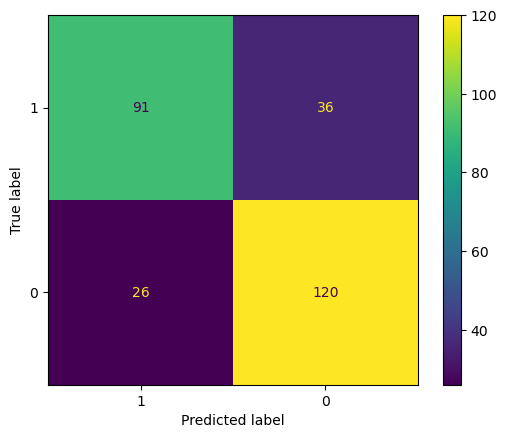

In [206]:
# Best KNN confustion matrix

labels = ha['output'].unique()
ConfusionMatrixDisplay(cm_best_knn, display_labels = labels).plot()

In [265]:
# cross-validated roc auc
knn_rocauc = cross_val_score(best_knn, X, y, cv=5, scoring="roc_auc")
knn_rocauc.mean()

0.850684350132626

In [266]:
# cross-validated accuracy
knn_acc = cross_val_score(best_knn, X, y, cv=5, scoring="accuracy")
knn_acc.mean()

0.7725925925925925

In [267]:
# tpr - recall
knn_tpr = cross_val_score(best_knn, X, y, cv=5, scoring="recall")
knn_tpr.mean()

0.8213793103448277

In [268]:
# ppv - precision
knn_ppv = cross_val_score(best_knn, X, y, cv=5, scoring="precision")
knn_ppv.mean()

0.7697703633424695

In [303]:
# tnr - specificity
knn_tn = cm_best_knn[1,1]
knn_fp = cm_best_knn[1,0]
knn_tnr = knn_tn / (knn_tn + knn_fp)
knn_tnr

0.821917808219178

In [346]:
# store values for further comparison summary

knn1_roc_auc = cross_val_score(best_knn, X, y, cv=5, scoring="roc_auc").mean()
knn1_precision = cross_val_score(best_knn, X, y, cv=5, scoring="precision").mean()
knn1_recall = cross_val_score(best_knn, X, y, cv=5, scoring="recall").mean()

### Logistic Regression 1

In [236]:
# LogReg pipe

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [237]:
# tunning parameters # assisted by ChatGPT
param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'saga'],       # Optimization algorithm
    'logreg__l1_ratio': [0.5]                      # ElasticNet mixing (only for 'elasticnet')
}

In [238]:
gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='roc_auc')
gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is o

Best parameters:  {'logreg__C': 1, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score:  0.8562518125552607
Best parameters:  {'logreg__C': 1, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score:  0.8562518125552607


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is o

In this LogReg model tuning based on ROC AUC score, best parameters are:
- Best parameters: 'logreg__C': 1, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'
- Best cross-validation score:  0.8562518125552607

In [239]:
# y_pred with best logreg cross_val_predict
best_logreg = gsvc.best_estimator_
y_pred = cross_val_predict(best_logreg, X, y, cv=5)
cm_best_logreg = confusion_matrix(y, y_pred)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred))
print("ROC AUC score: ", roc_auc_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy score:  0.7838827838827839
ROC AUC score:  0.7820623449466078
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76       127
           1       0.79      0.81      0.80       146

    accuracy                           0.78       273
   macro avg       0.78      0.78      0.78       273
weighted avg       0.78      0.78      0.78       273

Accuracy score:  0.7838827838827839
ROC AUC score:  0.7820623449466078
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76       127
           1       0.79      0.81      0.80       146

    accuracy                           0.78       273
   macro avg       0.78      0.78      0.78       273
weighted avg       0.78      0.78      0.78       273



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


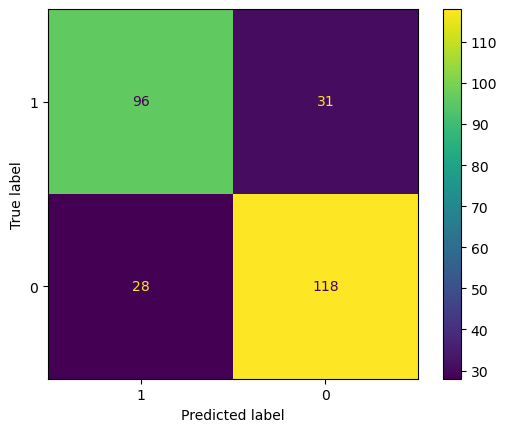

In [240]:
# Best LogReg confustion matrix

labels = ha['output'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

In [271]:
# cross-validated roc auc
logreg_rocauc = cross_val_score(best_logreg, X, y, cv=5, scoring="roc_auc")
logreg_rocauc.mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


0.8562518125552607

In [272]:
# cross-validated accuracy
logreg_acc = cross_val_score(best_logreg, X, y, cv=5, scoring="accuracy")
logreg_acc.mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


0.7837710437710438

In [273]:
# tpr - recall
logreg_tpr = cross_val_score(best_logreg, X, y, cv=5, scoring="recall")
logreg_tpr.mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


0.8082758620689656

In [274]:
# ppv - precision
logreg_ppv = cross_val_score(best_logreg, X, y, cv=5, scoring="precision")
logreg_ppv.mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


0.7953886051842114

In [302]:
# tnr - specificity
logreg_tn = cm_best_logreg[1,1]
logreg_fp = cm_best_logreg[1,0]
logreg_tnr = logreg_tn / (logreg_tn + logreg_fp)
logreg_tnr

0.8082191780821918

In [347]:
# store values for further comparison summary

logreg1_roc_auc = cross_val_score(best_logreg, X, y, cv=5, scoring="roc_auc").mean()
logreg1_precision = cross_val_score(best_logreg, X, y, cv=5, scoring="precision").mean()
logreg1_recall = cross_val_score(best_logreg, X, y, cv=5, scoring="recall").mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is o

In [276]:
# extract coefficients into a dataframe

columns_to_extract = X.head().columns.tolist()  # list of columns from 'X head'
beta_headers = [col for col in columns_to_extract if col != X.head().index.name] # Ensures index column is skipped

coef_df_LogReg = pd.DataFrame({'Variable': beta_headers, 'Coef_LogReg': best_logreg.named_steps['logreg'].coef_.flatten()})
coef_df_LogReg.sort_values(by=['Coef_LogReg'], ascending=False)

,Variable,Coef_LogReg
6,thalach,0.874019
2,cp,0.850121
5,restecg,0.151691
0,age,-0.224697
4,chol,-0.249709
3,trtbps,-0.372789
1,sex,-0.938172


### Coefficients interpretation - LogReg
Based on the estimated coefficients in this Logistic Regression model, 'thalach' variable (maximum heart rate achieved during exercise) and 'cp' chest pain type have the highset impact on the 'output' variable (ie. 1 standardized unit increase in either of these two variables contributes to an increase in value of 'output = 1' log-odds prediction). Interestingly, cholesterol level 'chol' is negatively associated with the 'output' variable in this regularized LogisticRegression model, although 'chol' level is commonly associated with as a heart-health risk factor. Also, 'sex' (1 = male) with a negative coefficient - decreases the log-odds of output value '1' in this model.

### Decision Tree 1

In [251]:
# DecisionTree pipe

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object))
   # ("standardize", # comment out standardzization for easier interpretation further
   # StandardScaler(),
   # make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

tree_pipe = Pipeline(
  [("preprocessing", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

In [252]:
# tunning decision tree model with multiple parameters # note: params suggested by ChatGPT

param_grid = {
    'tree__min_samples_leaf': [1, 2, 3, 5, 8, 10, 12],
    'tree__max_depth': [2, 3, 4, 5, 6],
    'tree__ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.10],
    'tree__min_impurity_decrease': [0.0, 0.01, 0.05]
}

gsvc = GridSearchCV(tree_pipe, param_grid, cv=5, scoring='roc_auc')
gsvc.fit(X, y)


print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)

Best parameters:  {'tree__ccp_alpha': 0.0, 'tree__max_depth': 3, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 8}
Best cross-validation score:  0.820613969938108
Best parameters:  {'tree__ccp_alpha': 0.0, 'tree__max_depth': 3, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 8}
Best cross-validation score:  0.820613969938108


Best parameters:  'tree__ccp_alpha': 0.0, 'tree__max_depth': 3, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 8

Best cross-validation score:  0.820613969938108

In [253]:
# y_pred with best dt cross_val_predict
best_tree = gsvc.best_estimator_
y_pred = cross_val_predict(best_tree, X, y, cv=5)
cm_best_tree = confusion_matrix(y, y_pred)

# scores
print("Accuracy score: ", accuracy_score(y, y_pred))
print("ROC AUC score: ", roc_auc_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy score:  0.7692307692307693
ROC AUC score:  0.7699007658289289
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       127
           1       0.80      0.76      0.78       146

    accuracy                           0.77       273
   macro avg       0.77      0.77      0.77       273
weighted avg       0.77      0.77      0.77       273

Accuracy score:  0.7692307692307693
ROC AUC score:  0.7699007658289289
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       127
           1       0.80      0.76      0.78       146

    accuracy                           0.77       273
   macro avg       0.77      0.77      0.77       273
weighted avg       0.77      0.77      0.77       273



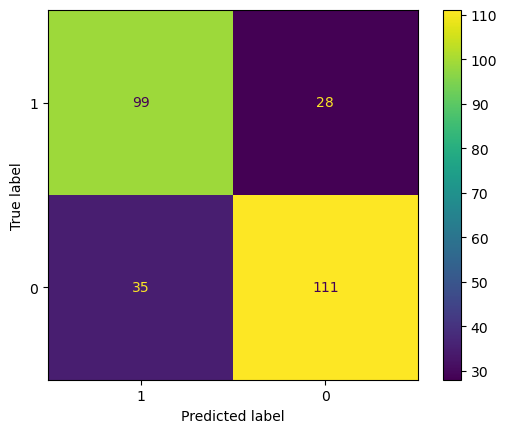

In [254]:
# Best Decisin Tree confustion matrix

labels = ha['output'].unique()
ConfusionMatrixDisplay(cm_best_tree, display_labels = labels).plot()

In [277]:
# cross-validated roc auc
tree_rocauc = cross_val_score(best_tree, X, y, cv=5, scoring="roc_auc")
tree_rocauc.mean()

0.820613969938108

In [278]:
# cross-validated accuracy
tree_acc = cross_val_score(best_tree, X, y, cv=5, scoring="accuracy")
tree_acc.mean()

0.7690909090909092

In [279]:
# tpr - recall
tree_tpr = cross_val_score(best_tree, X, y, cv=5, scoring="recall")
tree_tpr.mean()

0.7604597701149425

In [280]:
# ppv - precision
tree_ppv = cross_val_score(best_tree, X, y, cv=5, scoring="precision")
tree_ppv.mean()

0.7986013986013987

In [304]:
# tnr - specificity
tree_tn = cm_best_tree[1,1]
tree_fp = cm_best_tree[1,0]
tree_tnr = tree_tn / (tree_tn + tree_fp)
tree_tnr

0.7602739726027398

In [348]:
# store values for further comparison summary

tree1_roc_auc = cross_val_score(best_tree, X, y, cv=5, scoring="roc_auc").mean()
tree1_precision = cross_val_score(best_tree, X, y, cv=5, scoring="precision").mean()
tree1_recall = cross_val_score(best_tree, X, y, cv=5, scoring="recall").mean()

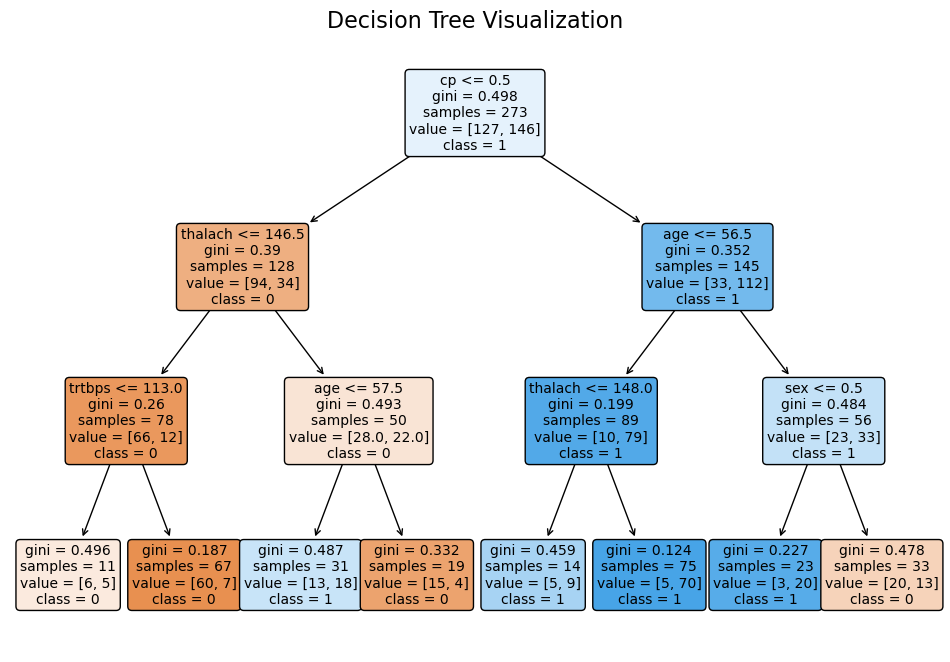

In [282]:
# EXTRA - Decision Tree Visualization # Assissted by ChatGPT

import matplotlib.pyplot as plt
b_tree = best_tree.named_steps['tree']

plt.figure(figsize=(12,8))
plot_tree(
    b_tree,
    feature_names = X.columns,
    class_names=[str(cls) for cls in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=10

)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

In the above 'decision tree' plot, we can see how the 'best' Decision Tree model classifies observations based on key 'predictor' variables to decrease impurity and the associated 'gini' impurity index at each step. Also, we can see how the sample is divided and which class is assigned as 'dominant'. Also, interesting to observe how the 'leading' predictor variable changes from step to step.

### Summary of 1A models:


In [290]:
df_models_rocauc = pd.DataFrame({
    'Model': ['KNN', 'LogReg', 'DecisionTree'],
    'ROC AUC score': [knn_rocauc.mean(), logreg_rocauc.mean(), tree_rocauc.mean()]
    })

df_models_rocauc.sort_values('ROC AUC score', ascending=False)

,Model,ROC AUC score
1,LogReg,0.856252
0,KNN,0.850684
2,DecisionTree,0.820614


With this variables selection (all 'non-output' predictors) and tuning of the models, LogisticRegression yields the highest ROC AUC score of 0.856, KNN is sligthly lower (0.85) and DecisionTree (while arguably the most transparent in to interpret) has the lowest ROC AUC score of 0.82.

In terms of best predictors, the results are somewhat mixed between the Logistic Regression and Decision Tree models, however 'cp' (chest pain type) and 'thalach' (maximum heart rate achieved during exercise) appear to be the most important predictors to hear attack risk 'output'.

### Note on other selection of predictor variables:
With the copy of the all above code for pipelines and cross-validate scores, tried manually running the above models on different sets of predictor variables in a separate notebook copy (to avoid clutter in this final version), from minimal X = ['cp', 'thalach', 'sex'] to more expansive or logical eg. + 'chol', 'age', etc. However, in most cases the overal scores for the models were lower, except for a few cases, where KNN model benefited from a narrower set of 'predictors' eg.['cp', 'thalach', 'sex'] and the best range of neigbors decreased to eg. n=28, yielding a slightly higher ROC score: 0.863, although in other models the ROC scores dropped significantly eg. LogReg: 0.838603, which didn't seem like an overeall better choice to reduce the amount of predictors with a relatively small dataset like this.

Finally, I also tried verifying the optimal set of predictors with 'Lasso' regression, however the outcome was that 'all predictors' available are the best selection. See a simpified version of the code in the APPENDIX section. Therefore, I proceed with 'all available' predictors for further models analysis.

### ROC Curve

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
<positron-console-cell-285>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt st

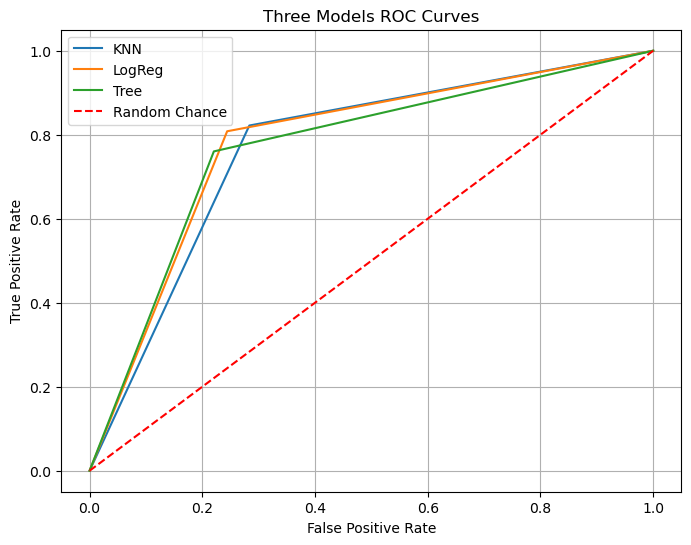

In [285]:
# ROC plot - three models # assissted by ChatGPT

y_1 = (y == 1)
y_pred_knn = cross_val_predict(best_knn, X, y_1, cv=5)
y_pred_logreg = cross_val_predict(best_logreg, X, y_1, cv=5)
y_pred_tree = cross_val_predict(best_tree, X, y_1, cv=5)


fpr_knn, tpr_knn, _ = roc_curve(y_1, y_pred_knn)
fpr_logreg, tpr_logreg, _ = roc_curve(y_1, y_pred_logreg)
fpr_tree, tpr_tree, _ = roc_curve(y_1, y_pred_tree)


# ROC Plot - Option 1: direct plot with pyplot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN")
plt.plot(fpr_logreg, tpr_logreg, label=f"LogReg")
plt.plot(fpr_tree, tpr_tree, label=f"Tree")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance", color = 'red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Three Models ROC Curves")
plt.legend(loc="best")
plt.grid()
plt.show()

In [287]:
# Plot - Option 2: # Assisted by ChatGPT
# df for plotnine plot
roc_df_knn = pd.DataFrame({'FPR': fpr_knn, 'TPR': tpr_knn, 'Model': 'KNN'})
roc_df_logreg = pd.DataFrame({'FPR': fpr_logreg, 'TPR': tpr_logreg, 'Model': 'LogReg'})
roc_df_tree = pd.DataFrame({'FPR': fpr_tree, 'TPR': tpr_tree, 'Model': 'Tree'})

roc_df = pd.concat([roc_df_knn, roc_df_logreg, roc_df_tree], ignore_index=True)

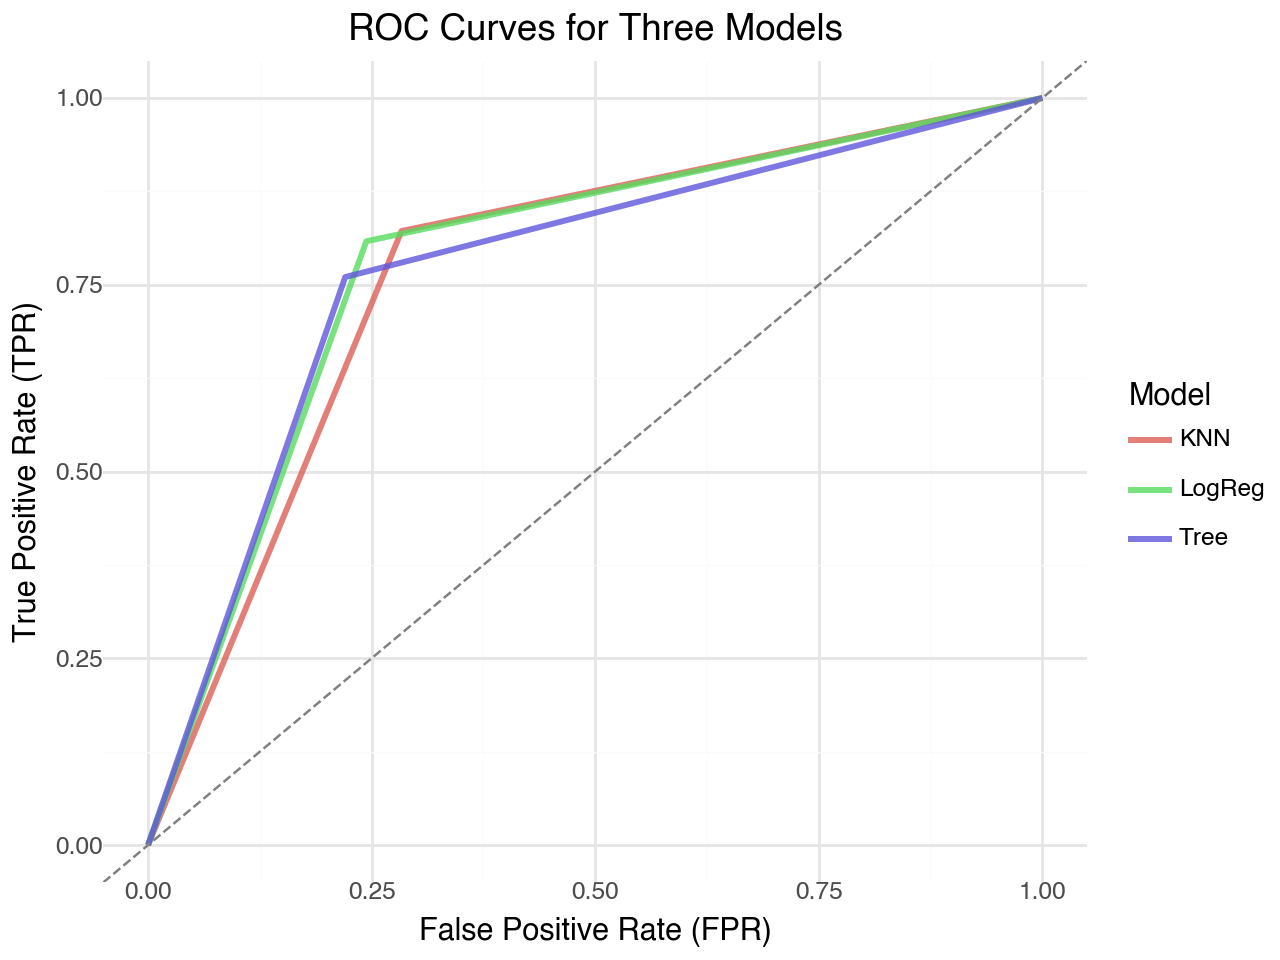

In [288]:
(ggplot(roc_df, aes(x='FPR', y='TPR', color='Model'))
    + geom_line(size=1.2, alpha = 0.8)  # Draw ROC curves
    + geom_abline(linetype='dashed', color='grey')  # Random chance line
    + labs(
        title="ROC Curves for Three Models",
        x="False Positive Rate (FPR)",
        y="True Positive Rate (TPR)",
        color="Model"
    )
    + theme_minimal()
)

## Part Two: Metrics

TPR, PPV and TNR metrics were already estimated in the previous part. Assuming 'class A' refers to output = '1'.

In [309]:
# True Positive Rate

df_models_tpr = pd.DataFrame({
    'Model': ['KNN', 'LogReg', 'DecisionTree'],
    'Recall score': [knn_tpr.mean(), logreg_tpr.mean(), tree_tpr.mean()]
    })

df_models_tpr.sort_values('Recall score', ascending=False)

,Model,Recall score
0,KNN,0.821379
1,LogReg,0.808276
2,DecisionTree,0.760460


In [310]:
# Precision

df_models_ppv = pd.DataFrame({
    'Model': ['KNN', 'LogReg', 'DecisionTree'],
    'Precision score': [knn_ppv.mean(), logreg_ppv.mean(), tree_ppv.mean()]
    })

df_models_ppv.sort_values('Precision score', ascending=False)

,Model,Precision score
2,DecisionTree,0.798601
1,LogReg,0.795389
0,KNN,0.769770


In [311]:
# True Negative Rate

df_models_tnr = pd.DataFrame({
    'Model': ['KNN', 'LogReg', 'DecisionTree'],
    'Specificity score': [knn_tnr, logreg_tnr, tree_tnr]
    })

df_models_tnr.sort_values('Specificity score', ascending=False)

,Model,Specificity score
0,KNN,0.821918
1,LogReg,0.808219
2,DecisionTree,0.760274


KNN has the highest TPR (Recall) and TNR (Specificity) scores of all models, while Decision Tree and Logistic Regression have the highest Precision score.

## Part Three: Discussion

Q1: 
For this risk-averse scenario (avoiding mislabelling a 'true positive' outcomes as 'negative'), the suggestion is to look at the model with the highest Recall 'TPR' score (ie. a model where the 'false negative' portion of the denominator in the 'Recall equation' is the lowest). In this case KNN model has the highest TPR score and can be recommended for this client case. The client can then expect that following this model will correctly classify (predict) at least 82% of the future (true positive) observations. Ie. the risk of mis-classifying 'at-risk' observations as 'no risk' will be minimized to 18%, comapred to other models.

Q2: In this scenario, the client can use the metric that focuses on proper classification of 'true positives' and minimize the share of 'false positives', such as 'Precision score'. Based on this metric, DecisionTree and LogReg models hold the highest scores. However, considering another alternative metric 'specificity' or TNR that also can reflect the minimized 'false positive' share in the denominator, LogisticRegression has the second lowest TNR and therefore holds a better balance compared to DecisionTree. Hence, 'Logistic Regression' can be a preferred model in this case, and the client can expect that the rate of predicted 'false positives' by this model will be minimized to approx. 20%.

Q3: In this case it's best to look at the model where a. the 'precision' of classification is high (ie. 'false positive' observations are minimized) and the model and it's coefficients are easy to interpret. Both 'Logistic Regression' and 'Decision Tree' models provide insight on coefficients or key 'influence' metrics and both have the highest 'precision' score approx 0.79, meaning that share of misclassified 'false positive' observations is minimized to approx 20%. 
Considering that 'Decision Tree' can be easier to follow step-by-step and provide more insight, this can be a preferred model for this case, also having the highest Precision score. However, a LogisticRegression model can also provide more 'high' level or generalized with the estimated coefficients (although don't conclude a direct causality), that can be used for additional insight.

Q4: In this scenario, the key metrics to consider are related to ability to correctly identify a 'true' outcome out and minimize 'false' negatives/positives. Therefore both 'Recall' and 'Specificity' can be good metrics to analyze. Based on these two metrics, KNN model has the highest score and will be best at predicting the outcomes, with lowest expected 'mis-classification' in the denominator/s. An F-1 score can also be a good alternative metric as it's easier to standardize and compare eg. for doctors with different numbers of observations.

## Part Four: Validation

In [307]:
# data
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1").dropna()

In [312]:
# variables
X = ha_validation.drop(columns='output')
y = ha_validation['output']

### KNN 2

In [322]:
# prediction
y_pred2_knn = best_knn.predict(X)

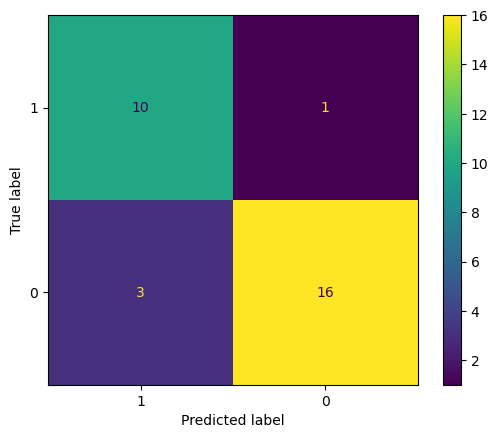

In [329]:
# confusion matrix
cm_knn_2 = confusion_matrix(y, y_pred2_knn)
labels = ha_validation['output'].unique()
ConfusionMatrixDisplay(cm_knn_2, display_labels = labels).plot()

In [335]:
# scores and classification report
print("ROC AUC score: ", roc_auc_score(y, y_pred2_knn))
print("Precision score: ", precision_score(y, y_pred2_knn))
print("Recall score: ", recall_score(y, y_pred2_knn))
print("Classification Report:\n", classification_report(y, y_pred2_knn))

ROC AUC score:  0.8755980861244018
Precision score:  0.9411764705882353
Recall score:  0.8421052631578947
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.94      0.84      0.89        19

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30

ROC AUC score:  0.8755980861244018
Precision score:  0.9411764705882353
Recall score:  0.8421052631578947
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.94      0.84      0.89        19

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [336]:
# store values for further comparison summary
knn2_roc_auc = roc_auc_score(y, y_pred2_knn)
knn2_precision = precision_score(y, y_pred2_knn)
knn2_recall = recall_score(y, y_pred2_knn)

### Logistic Regression 2

In [337]:
# prediction
y_pred2_logreg = best_logreg.predict(X)

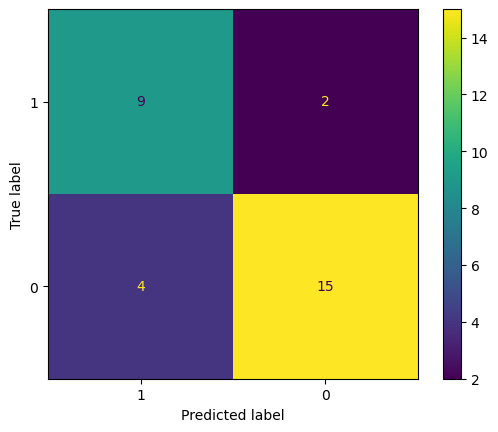

In [338]:
# confusion matrix
cm_logreg_2 = confusion_matrix(y, y_pred2_logreg)
labels = ha_validation['output'].unique()
ConfusionMatrixDisplay(cm_logreg_2, display_labels = labels).plot()

In [339]:
# scores and classification report
print("ROC AUC score: ", roc_auc_score(y, y_pred2_logreg))
print("Precision score: ", precision_score(y, y_pred2_logreg))
print("Recall score: ", recall_score(y, y_pred2_logreg))
print("Classification Report:\n", classification_report(y, y_pred2_logreg))

ROC AUC score:  0.8038277511961722
Precision score:  0.8823529411764706
Recall score:  0.7894736842105263
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.88      0.79      0.83        19

    accuracy                           0.80        30
   macro avg       0.79      0.80      0.79        30
weighted avg       0.81      0.80      0.80        30

ROC AUC score:  0.8038277511961722
Precision score:  0.8823529411764706
Recall score:  0.7894736842105263
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.88      0.79      0.83        19

    accuracy                           0.80        30
   macro avg       0.79      0.80      0.79        30
weighted avg       0.81      0.80      0.80        30



In [340]:
# store values for further comparison summary
logreg2_roc_auc = roc_auc_score(y, y_pred2_logreg)
logreg2_precision = precision_score(y, y_pred2_logreg)
logreg2_recall = recall_score(y, y_pred2_logreg)

### Decision Tree 2

In [341]:
# prediction
y_pred2_tree = best_tree.predict(X)

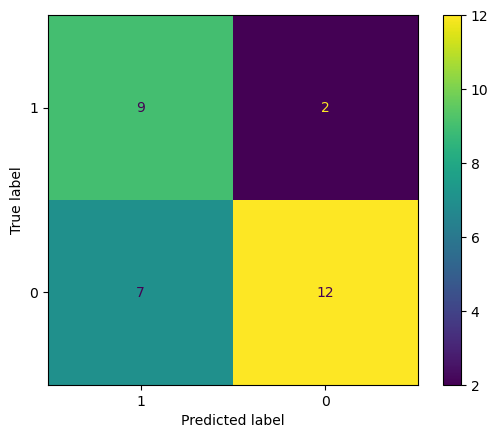

In [342]:
# confusion matrix
cm_tree_2 = confusion_matrix(y, y_pred2_tree)
labels = ha_validation['output'].unique()
ConfusionMatrixDisplay(cm_tree_2, display_labels = labels).plot()

In [343]:
# scores and classification report
print("ROC AUC score: ", roc_auc_score(y, y_pred2_tree))
print("Precision score: ", precision_score(y, y_pred2_tree))
print("Recall score: ", recall_score(y, y_pred2_tree))
print("Classification Report:\n", classification_report(y, y_pred2_tree))

ROC AUC score:  0.7248803827751196
Precision score:  0.8571428571428571
Recall score:  0.631578947368421
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.86      0.63      0.73        19

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71        30

ROC AUC score:  0.7248803827751196
Precision score:  0.8571428571428571
Recall score:  0.631578947368421
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.86      0.63      0.73        19

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71        30



In [344]:
# store values for further comparison summary
tree2_roc_auc = roc_auc_score(y, y_pred2_tree)
tree2_precision = precision_score(y, y_pred2_tree)
tree2_recall = recall_score(y, y_pred2_tree)

In [349]:
# compare results in a dataframe

df_all_models = pd.DataFrame({
    'Model': ['KNN 1', 'KNN 2', 'LogReg 1', 'LogReg 2', 'DecisionTree 1', 'DecisionTree 2'],
    'ROC AUC': [knn1_roc_auc, knn2_roc_auc, logreg1_roc_auc, logreg2_roc_auc, tree1_roc_auc, tree2_roc_auc],
    'Precision': [knn1_precision, knn2_precision, logreg1_precision, logreg2_precision, tree1_precision, tree2_precision],
    'Recall': [knn1_recall, knn2_recall, logreg1_recall, logreg2_recall, tree1_recall, tree2_recall]
    })
df_all_models

,Model,ROC AUC,Precision,Recall
0,KNN 1,0.850684,0.769770,0.821379
1,KNN 2,0.875598,0.941176,0.842105
2,LogReg 1,0.856252,0.795389,0.808276
3,LogReg 2,0.803828,0.882353,0.789474
4,DecisionTree 1,0.820614,0.798601,0.760460
5,DecisionTree 2,0.724880,0.857143,0.631579


As we can see, KNN is the only model from which prediction on the validation dataset outperfomed the intitial cross-validated dataset across all three metrics 'ROC AUC', 'Precision' and 'Recall'.
Logistic Regression had comparable scores between 1 and 2 on Recall, a lower ROC but a substantially higher Precision score on validation data 2.
As for the Decision Tree model, the validation data 2 prediction scores on ROC AUC and Recall were substantially lower than with the cross-validated data 1. The precision score increased in the validation data set.

Overall, KNN appears to be 'the best' predictive model in this case.

## Part Five: Cohen’s Kappa

In [352]:
y_pred1_knn = cross_val_predict(best_knn, X, y, cv=5)
y_pred1_logreg = cross_val_predict(best_logreg, X, y, cv=5)
y_pred1_tree = cross_val_predict(best_tree, X, y, cv=5)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


In [355]:
knn1_kappa = cohen_kappa_score(y, y_pred1_knn)
logreg1_kappa = cohen_kappa_score(y, y_pred1_logreg)
tree1_kappa = cohen_kappa_score(y, y_pred1_tree)

In [357]:
df_kappa_1 = pd.DataFrame({
    'Model': ['KNN 1', 'LogReg 1', 'DecisionTree 1'],
    'Cohen Kappa': [knn1_kappa, logreg1_kappa, tree1_kappa]
    })
df_kappa_1

,Model,Cohen Kappa
0,KNN 1,0.541226
1,LogReg 1,0.564993
2,DecisionTree 1,0.537872


When analyzing the results of the models from 'Part One' based on Cohen's Kappa, a 'Logistic Regression' has a slightly higher score than 'KNN' and 'Decision Tree' (implying that Logistic Regression model may be better at generalizating and provide more accurate predictions), however the difference in scores between the models are fairly minor <5%. All of the models fall under 'Moderate Agreement' range [0.41-0.60] and neither are performing exceptionally well when compared by this metric.

The above results are somewhat consistent with prior findings, when comparing between 'KNN' and 'LogReg' switching between first and runner-up on certain metrics scores, although this metric shows that both models are not as predictive validity is not as strong as measured by other metrics earlier. It may be good to include Cohen Kappa when comapring and choosing between either of these models for specific use-case scenario and also during the process alongside other metrics such as 'ROC AUC', 'precision' and 'recall'.

## APPENDIX

## 1. Variables selection with Lasso regression

In [164]:
# Verifying best predictor variables selection with Lasso regression # Assisted by ChatGPT
# Lasso pipeline

lasso_pipeline = Pipeline(
    [("preprocessing", ct),
    ("lasso", Lasso())]
).set_output(transform="pandas")


param_grid = {'C': np.logspace(-4, 4, 50)}  # Test C values on a log scale 
gsvc = GridSearchCV(lasso, param_grid, cv=5, scoring='roc_auc')
gsvc.fit(X, y)

# Best regularization parameter
print("Best C:", gsvc.best_params_['C'])

# Fit Lasso with the best C
best_lasso = gsvc.best_estimator_
fitted_lasso = best_lasso.fit(X, y)

# Extract selected features
selected_features = X.columns[best_lasso.coef_[0] != 0]
print("Selected features:", selected_features)

Best C: 0.5689866029018293
Selected features: Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach'], dtype='object')
Best C: 0.5689866029018293
Selected features: Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach'], dtype='object')


In [51]:
# df of coefficients # note: output from another 'messy' Lasso model

coef_df_Lasso = pd.DataFrame({'Variable': beta_headers, 'Coef_Lasso': lasso_fitted.named_steps['lasso_regression'].coef_})
coef_df_Lasso.sort_values(by=['Coef_Lasso'], ascending=False)

,Variable,Coef_Lasso
2,cp,0.147389
6,thalach,0.127908
5,restecg,0.020977
4,chol,-0.026699
0,age,-0.034514
3,trtbps,-0.049645
1,sex,-0.137539
